# EXTENSION: Additional Evaluations

Our approach differs from token-level entropy by calculating "semantic entropy" over a broader context. However, TriviaQA's short-answer format may not fully showcase this difference. The gap between token-level and semantic-level entropy values might be subtle in such cases. To better evaluate our method, we'll test it on two datasets that require longer, more detailed responses.

## Analysis II: Commonsense QA Dataset

Here, we will ask the model to give its reasoning first and then share the final answer. So that, the very first tokens of the model's response won't be signaling its final answer, and we will be able to understand the impact of semantic-level entropy compared to token-level entropy

### Tasks:

1) Create train/validation/test splits. \\
2) Choose few shot examples, exclude them from the splits \\

## Set Up:

In [ ]:
!pip install transformers datasets torch tqdm scikit-learn matplotlib accelerate

In [ ]:
#!pip install --upgrade pyarrow datasets

In [ ]:
#!pip install pyarrow==14.0.1
#!pip install --upgrade datasets

In [3]:
import torch
import accelerate
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import load_from_disk, load_dataset
import random
import math
import os
from google.colab import drive
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
import os
token = os.environ['HF_TOKEN']

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the base path in your Google Drive
base_path = "/content/drive/MyDrive/hallucination-detector/"

# Create the directory if it doesn't exist
import os
os.makedirs(base_path, exist_ok=True)

## Data Preprocessing

In [ ]:
# Load the dataset
cs_dataset = load_dataset("tau/commonsense_qa", "default")
cs_train = cs_dataset['train']
cs_valid = cs_dataset['validation']
cs_test = cs_dataset['test']

# Shuffle the dataset
cs_train = cs_train.shuffle(seed=42)
cs_valid = cs_valid.shuffle(seed=42)
cs_test = cs_test.shuffle(seed=42)

In [ ]:
train_ds = cs_train.select(range(5000))
valid_ds = cs_train.select(range(5000,6500))
test_ds = cs_valid

print(f"training split size: {len(train_ds)}")
print(f"validation split size: {len(valid_ds)}")
print(f"test split size: {len(test_ds)}")

training split size: 5000
validation split size: 1500
test split size: 1221


## Model Testing

In [ ]:
print("Loading Gemma 2B model and tokenizer...")
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it", token=token)
gemma_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    output_hidden_states=True,
    token=token
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For fair evaluation, few-shot examples are typically chosen randomly. However, in this case, we aim to maximize the model's accuracy to ensure a sufficient number of positively labeled sequences. This allows the model to effectively learn the contrast between hallucinated and non-hallucinated content. Due to the complexity of the task and the size of the Gemma-2B model, the model is likely to hallucinate or miss the desired format in most instances. Therefore, to provide the model with the best possible assistance, we carefully hand-selected the few-shot examples.

## Creating Best Guess Answer and the Embedding

In [ ]:
#7.30pm version
import pandas as pd
import torch
import os
from tqdm import tqdm
import numpy as np

examples = [
    {
        "question": "If you see your favorite show and it's a comedy you'll likely do what?",
        "choices": ["watch tv", "smile", "laugh", "relax", "buy tickets"],
        "reasoning": "Comedies are meant to be funny and makes you laugh.",
        "answer": "C"
    },
    {
        "question": "What planet is the Atlantic Ocean part of?",
        "choices": ["planet", "basin", "submarines", "earth", "pacific"],
        "reasoning": "The Atlantic is one of Earth's oceans.",
        "answer": "D"
    },
    {
        "question": "What could happen when beginning work after it is too late?",
        "choices": ["deadlines", "panic", "accomplishing", "momentum", "sitting down"],
        "reasoning": "Starting late often causes stress and panic.",
        "answer": "B"
    }
]

def format_test_question(question, choices):
    formatted_choices = "\n".join([f"{chr(65+i)}) {choice}" for i, choice in enumerate(choices)])
    example_text = "Examples:\n\n"
    for ex in examples[:3]:  # Using first 3 examples to keep prompt length manageable
        ex_choices = "\n".join([f"{chr(65+i)}) {choice}" for i, choice in enumerate(ex['choices'])])
        example_text += f"""Question: {ex['question']}
Choices:
{ex_choices}
Reasoning: {ex['reasoning']}
Final answer: #### {ex['answer']}) {ex['choices'][ord(ex['answer']) - ord('A')]}
"""
    example_text += "Now, please answer this question using the SAME FORMAT:\n\n"
    return f"""{example_text}Question: {question}
Choices:
{formatted_choices}
IMPORTANT: You must follow these steps:
1. Provide your short reasoning, starting with "Reasoning:"
2. After explaining, provide your answer starting with "Final answer: ####"
Your response:
"""

def generate_greedy_answer_and_embedding(questions, choices, num_additional_tokens=500):
    formatted_questions = [format_test_question(q, c['text']) for q, c in zip(questions, choices)]
    inputs = gemma_tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(device)
    question_lengths = inputs.attention_mask.sum(dim=1)
    max_length = inputs.input_ids.size(1) + num_additional_tokens

    with torch.no_grad():
        generation_outputs = gemma_model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=1,
            do_sample=False,
            temperature=0,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

        generated_sequences = generation_outputs.sequences
        full_responses = gemma_tokenizer.batch_decode(generated_sequences, skip_special_tokens=True)
        answers = [full_response[len(formatted_q):].strip() for full_response, formatted_q in zip(full_responses, formatted_questions)]

        # Extract the last token's embedding for each question
        last_token_embeddings = [generation_outputs.hidden_states[0][-1][i][question_length-1].float().cpu().numpy()
                                 for i, question_length in enumerate(question_lengths)]

    # Clear intermediate variables
    del inputs, generation_outputs, generated_sequences
    torch.cuda.empty_cache()

    return answers, last_token_embeddings

def process_dataset_greedy(dataset, name, batch_size=32):
    output_file = f"/content/drive/MyDrive/hallucination-detector/cs_qa_{name}_gemma_greedy_labels.csv"

    # Check for existing file and determine starting point
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        start_index = len(existing_df)
        results = existing_df.to_dict('records')
    else:
        start_index = 0
        results = []

    for i in tqdm(range(start_index, len(dataset), batch_size), desc=f"Processing {name}"):
        batch = dataset[i:i+batch_size]
        questions = batch['question']
        choices = batch['choices']
        answers = batch['answerKey']

        generated_answers, embeddings = generate_greedy_answer_and_embedding(questions, choices)

        for q, c, a, gen_a, emb in zip(questions, choices, answers, generated_answers, embeddings):
            results.append({
                'question': q,
                'choices': str(c),
                'answer': a,
                'generated_answer': gen_a,
                'embedding': emb.tolist()  # Convert numpy array to list for CSV storage
            })

        # Write to CSV after processing every batch
        df = pd.DataFrame(results)
        df.to_csv(output_file, index=False)
        print(f"Checkpoint saved. Processed {len(results)} questions.")

    print(f"{name.capitalize()} dataset processing complete. CSV file saved to {output_file}")

In [ ]:
process_dataset_greedy(train_ds, "train", 32)
process_dataset_greedy(valid_ds, "valid", 32)
process_dataset_greedy(test_ds, "test", 32)

## Creating 10-Answer Alternatives

In [ ]:
import pandas as pd
import torch
import os
from tqdm import tqdm
import json

# Assume these are properly imported and initialized
# from transformers import AutoModelForCausalLM, AutoTokenizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-7b").to(device)
# gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")

examples = [
    {
        "question": "If you see your favorite show and it's a comedy you'll likely do what?",
        "choices": ["watch tv", "smile", "laugh", "relax", "buy tickets"],
        "reasoning": "Comedies are meant to be funny and makes you laugh.",
        "answer": "C"
    },
    {
        "question": "What planet is the Atlantic Ocean part of?",
        "choices": ["planet", "basin", "submarines", "earth", "pacific"],
        "reasoning": "The Atlantic is one of Earth's oceans.",
        "answer": "D"
    },
    {
        "question": "What could happen when beginning work after it is too late?",
        "choices": ["deadlines", "panic", "accomplishing", "momentum", "sitting down"],
        "reasoning": "Starting late often causes stress and panic.",
        "answer": "B"
    }
]

def format_test_question(question, choices):
    formatted_choices = "\n".join([f"{chr(65+i)}) {choice}" for i, choice in enumerate(choices)])
    example_text = "Examples:\n\n"
    for ex in examples:
        ex_choices = "\n".join([f"{chr(65+i)}) {choice}" for i, choice in enumerate(ex['choices'])])
        example_text += f"""Question: {ex['question']}
Choices:
{ex_choices}
Reasoning: {ex['reasoning']}
Final answer: #### {ex['answer']}) {ex['choices'][ord(ex['answer']) - ord('A')]}
"""
    example_text += "Now, please answer this question using the SAME FORMAT:\n\n"
    return f"""{example_text}Question: {question}
Choices:
{formatted_choices}
IMPORTANT: You must follow these steps:
1. Provide your short reasoning, starting with "Reasoning:"
2. After explaining, provide your answer starting with "Final answer: ####"
Your response:
"""

def generate_multiple_answers_batch(questions, choices_list, num_answers=10, batch_size=4):
    all_answers = []
    for i in range(0, len(questions), batch_size):
        batch_questions = questions[i:i+batch_size]
        batch_choices = choices_list[i:i+batch_size]

        formatted_questions = [format_test_question(q, c['text']) for q, c in zip(batch_questions, batch_choices)]
        inputs = gemma_tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(device)

        with torch.no_grad():
            generation_outputs = gemma_model.generate(
                **inputs,
                max_length=inputs.input_ids.size(1) + 500,
                num_return_sequences=num_answers,
                do_sample=True,
                top_p=0.9,
                temperature=0.8,
            )

            # Reshape outputs to group by input
            generation_outputs = generation_outputs.view(len(batch_questions), num_answers, -1)

            for j, outputs in enumerate(generation_outputs):
                full_responses = gemma_tokenizer.batch_decode(outputs, skip_special_tokens=True)
                answers = [full_response[len(formatted_questions[j]):].strip() for full_response in full_responses]
                all_answers.append(answers)

        # Clear intermediate variables
        del inputs, generation_outputs
        torch.cuda.empty_cache()

    return all_answers

def process_dataset_multiple(dataset, name, batch_size=4):
    output_file = f"/content/drive/MyDrive/hallucination-detector/cs_qa_{name}_gemma_multiple_answers.csv"

    # Check for existing file and determine starting point
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        start_index = len(existing_df)
        results = existing_df.to_dict('records')
    else:
        start_index = 0
        results = []

    batch_count = 0
    for i in tqdm(range(start_index, len(dataset), batch_size), desc=f"Processing {name}"):
        batch = dataset[i:i+batch_size]
        questions = batch['question']
        choices = batch['choices']
        answers = batch['answerKey']

        generated_answers_batch = generate_multiple_answers_batch(questions, choices, batch_size=batch_size)

        for q, c, a, gen_a in zip(questions, choices, answers, generated_answers_batch):
            results.append({
                'question': q,
                'choices': json.dumps(c),  # Convert choices to JSON string
                'answer': a,
                'generated_answers': json.dumps(gen_a)  # Convert list to JSON string
            })

        batch_count += 1

        # Write to CSV after processing every 10 batches
        if batch_count % 10 == 0:
            df = pd.DataFrame(results)
            df.to_csv(output_file, index=False)
            print(f"Checkpoint saved. Processed {len(results)} questions.")

    # Save any remaining results
    if batch_count % 10 != 0:
        df = pd.DataFrame(results)
        df.to_csv(output_file, index=False)
        print(f"Final save. Processed {len(results)} questions.")

    print(f"{name.capitalize()} dataset processing complete. CSV file saved to {output_file}")

In [ ]:
process_dataset_multiple(train_ds, "train", batch_size=4)
process_dataset_multiple(valid_ds, "valid", batch_size=4)

## Analyze the Data

In [71]:
import pandas as pd
import ast
import re

# Define the base path
base_path = "/content/drive/MyDrive/hallucination-detector/"

# Load and merge train datasets
train_greedy_labels = pd.read_csv(f"{base_path}cs_qa_train_gemma_greedy_labels.csv")
train_multiple_answers = pd.read_csv(f"{base_path}cs_qa_train_gemma_multiple_answers.csv")
train_data = pd.concat([train_greedy_labels, train_multiple_answers.drop(['question', 'answer', 'choices'], axis=1)], axis=1)

# Load and merge valid datasets
valid_greedy_labels = pd.read_csv(f"{base_path}cs_qa_valid_gemma_greedy_labels.csv")
valid_multiple_answers = pd.read_csv(f"{base_path}cs_qa_valid_gemma_multiple_answers.csv")
valid_data = pd.concat([valid_greedy_labels, valid_multiple_answers.drop(['question', 'answer', 'choices'], axis=1)], axis=1)

# Load test dataset (no merging needed)
test_data = pd.read_csv(f"{base_path}cs_qa_test_gemma_greedy_labels.csv")

def extract_options(choices_string):
    try:
        choices_dict = ast.literal_eval(choices_string)
        options = choices_dict['text']
        if len(options) != 5:
            raise ValueError(f"Expected 5 options, but found {len(options)}")
        return options
    except (ValueError, KeyError, SyntaxError) as e:
        print(f"Error parsing choices: {e}")
        return []

def extract_answer(text, options):
    if not isinstance(text, str):
        return 'Z'

    text_lower = text.lower()
    options_lower = [opt.lower() for opt in options]

    # Check after ####
    if '####' in text_lower:
        after_hash = text_lower.split('####')[1].strip()

        # Look for options after ####
        for idx, option in enumerate(options_lower):
            if option in after_hash:
                return chr(65 + idx)

        # Look for A), B), C), D), E) after ####
        match = re.search(r'\b([a-e])\)', after_hash)
        if match:
            return match.group(1).upper()

    # Look for options in the whole text
    for idx, option in enumerate(options_lower):
        if option in text_lower:
            return chr(65 + idx)

    return 'Z'

# Process datasets
for dataset in [train_data, valid_data, test_data]:
    dataset['options'] = dataset['choices'].apply(extract_options)
    dataset['answer_pred'] = dataset.apply(lambda row: extract_answer(row['generated_answer'], row['options']), axis=1)
    dataset['is_correct'] = dataset['answer'] == dataset['answer_pred']

def print_distribution_accuracy_and_breakdown(dataset, title):
    print(f"\nDistribution for {title}:")

    # Predicted answer distribution
    pred_counts = dataset['answer_pred'].value_counts().reindex(['A', 'B', 'C', 'D', 'E', 'Z'], fill_value=0)
    pred_total = pred_counts.sum()
    pred_percentages = (pred_counts / pred_total * 100).round(2)

    print("Predicted Answer Distribution:")
    for answer, count in pred_counts.items():
        print(f"{answer}: {count} ({pred_percentages[answer]}%)")

    # Actual answer distribution
    actual_counts = dataset['answer'].value_counts().reindex(['A', 'B', 'C', 'D', 'E'], fill_value=0)
    actual_total = actual_counts.sum()
    actual_percentages = (actual_counts / actual_total * 100).round(2)

    print("\nActual Answer Distribution:")
    for answer, count in actual_counts.items():
        print(f"{answer}: {count} ({actual_percentages[answer]}%)")

    # Calculate accuracy
    accuracy = dataset['is_correct'].mean() * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")

    # Breakdown of correct predictions
    print("\nBreakdown of Correct Predictions:")
    for answer in ['A', 'B', 'C', 'D', 'E', 'Z']:
        predictions = dataset[dataset['answer_pred'] == answer]
        correct_predictions = predictions[predictions['is_correct']]
        total_predictions = len(predictions)
        correct_count = len(correct_predictions)
        if total_predictions > 0:
            percentage = round((correct_count / total_predictions) * 100, 2)
        else:
            percentage = 0.0
        print(f"{answer}: {correct_count} out of {total_predictions} ({percentage}%)")

# Print distributions, accuracy, and breakdown for each dataset
for name, data in [('Train', train_data), ('Valid', valid_data), ('Test', test_data)]:
    print_distribution_accuracy_and_breakdown(data, f'{name} Data')


Distribution for Train Data:
Predicted Answer Distribution:
A: 1380 (27.6%)
B: 272 (5.44%)
C: 367 (7.34%)
D: 235 (4.7%)
E: 74 (1.48%)
Z: 2672 (53.44%)

Actual Answer Distribution:
A: 968 (19.36%)
B: 1029 (20.58%)
C: 991 (19.82%)
D: 1031 (20.62%)
E: 981 (19.62%)

Overall Accuracy: 16.82%

Breakdown of Correct Predictions:
A: 364 out of 1380 (26.38%)
B: 134 out of 272 (49.26%)
C: 160 out of 367 (43.6%)
D: 129 out of 235 (54.89%)
E: 54 out of 74 (72.97%)
Z: 0 out of 2672 (0.0%)

Distribution for Valid Data:
Predicted Answer Distribution:
A: 378 (25.2%)
B: 94 (6.27%)
C: 118 (7.87%)
D: 61 (4.07%)
E: 22 (1.47%)
Z: 827 (55.13%)

Actual Answer Distribution:
A: 282 (18.8%)
B: 297 (19.8%)
C: 321 (21.4%)
D: 287 (19.13%)
E: 313 (20.87%)

Overall Accuracy: 15.53%

Breakdown of Correct Predictions:
A: 99 out of 378 (26.19%)
B: 42 out of 94 (44.68%)
C: 47 out of 118 (39.83%)
D: 32 out of 61 (52.46%)
E: 13 out of 22 (59.09%)
Z: 0 out of 827 (0.0%)

Distribution for Test Data:
Predicted Answer Distrib

In [72]:
import ast
import math
import re
from collections import Counter

def convert_string_to_list(string_representation):
    try:
        evaluated_list = ast.literal_eval(string_representation)
        if isinstance(evaluated_list, list) and len(evaluated_list) == 10:
            return [str(item) for item in evaluated_list]
        else:
            raise ValueError("The string does not represent a list of 10 elements")
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing the string: {e}")
        return None

def extract_answer(text, options):
    if not isinstance(text, str):
        return 'Z'

    text_lower = text.lower()
    options_lower = [opt.lower() for opt in options]

    # Check after ####
    if '####' in text_lower:
        after_hash = text_lower.split('####')[1].strip()

        # Look for options after ####
        for idx, option in enumerate(options_lower):
            if option in after_hash:
                return chr(65 + idx)

        # Look for A), B), C), D), E) after ####
        match = re.search(r'\b([a-e])\)', after_hash)
        if match:
            return match.group(1).upper()

    # Look for options in the whole text
    for idx, option in enumerate(options_lower):
        if option in text_lower:
            return chr(65 + idx)

    return 'Z'

def calculate_entropy(frequencies):
    total = sum(frequencies.values())
    entropy = 0
    for answer, count in frequencies.items():
        if answer != 'Z':
            p = count / total
            if p > 0:
                entropy -= p * math.log2(p)
        else:
            for _ in range(count):
                p = 1 / total
                entropy -= p * math.log2(p)
    return round(entropy, 2)  # Round to 2 decimal places

def process_generated_answers(df):
    def label_and_calculate_entropy(row):
        generated_answers = convert_string_to_list(row['generated_answers'])
        if generated_answers is None:
            return {'frequencies': {}, 'entropy': None}

        labeled_answers = [extract_answer(answer, row['options']) for answer in generated_answers]
        frequencies = Counter(labeled_answers)
        for answer in 'ABCDEZ':
            if answer not in frequencies:
                frequencies[answer] = 0

        entropy = calculate_entropy(frequencies)

        return {'frequencies': dict(frequencies), 'entropy': entropy}

    results = df.apply(label_and_calculate_entropy, axis=1)
    df['answer_frequencies'] = results.apply(lambda x: x['frequencies'])
    df['entropy'] = results.apply(lambda x: x['entropy'])

    return df

# Process train_data and valid_data
train_data = process_generated_answers(train_data)
valid_data = process_generated_answers(valid_data)

## Data Anlysis and Hallucination Detection Model Training

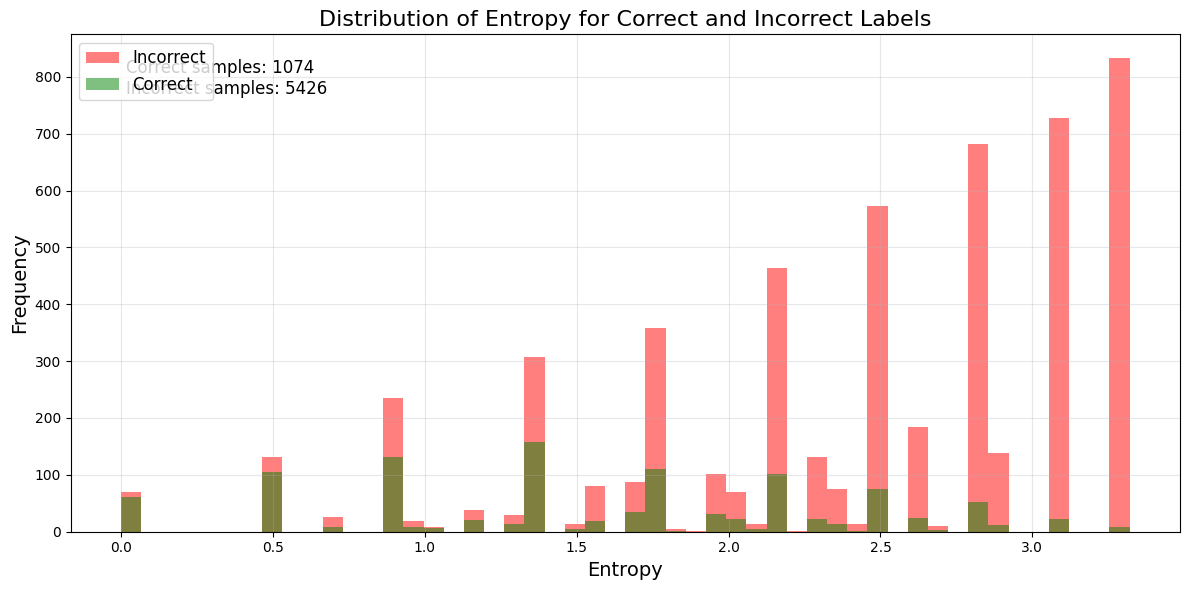

Correct labels - Mean: 1.5815, Std: 0.8158
Incorrect labels - Mean: 2.3951, Std: 0.8087


In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine train and valid data if they're separate
combined_df = pd.concat([train_data, valid_data], ignore_index=True)

# Separate the data for correct and incorrect labels
correct_entropy = combined_df[combined_df['is_correct'] == True]['entropy']
incorrect_entropy = combined_df[combined_df['is_correct'] == False]['entropy']

# Define the number of bins and range
bins = 50
range_min = min(combined_df['entropy'].min(), 0)  # In case there are negative values
range_max = combined_df['entropy'].max()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram for incorrect labels (red)
plt.hist(incorrect_entropy, bins=bins, range=(range_min, range_max), color='red', alpha=0.5, label='Incorrect')

# Plot histogram for correct labels (green)
plt.hist(correct_entropy, bins=bins, range=(range_min, range_max), color='green', alpha=0.5, label='Correct')

# Customize the plot
plt.title('Distribution of Entropy for Correct and Incorrect Labels', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add text with data statistics
plt.text(0.05, 0.95, f"Correct samples: {len(correct_entropy)}\nIncorrect samples: {len(incorrect_entropy)}",
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Correct labels - Mean: {correct_entropy.mean():.4f}, Std: {correct_entropy.std():.4f}")
print(f"Incorrect labels - Mean: {incorrect_entropy.mean():.4f}, Std: {incorrect_entropy.std():.4f}")

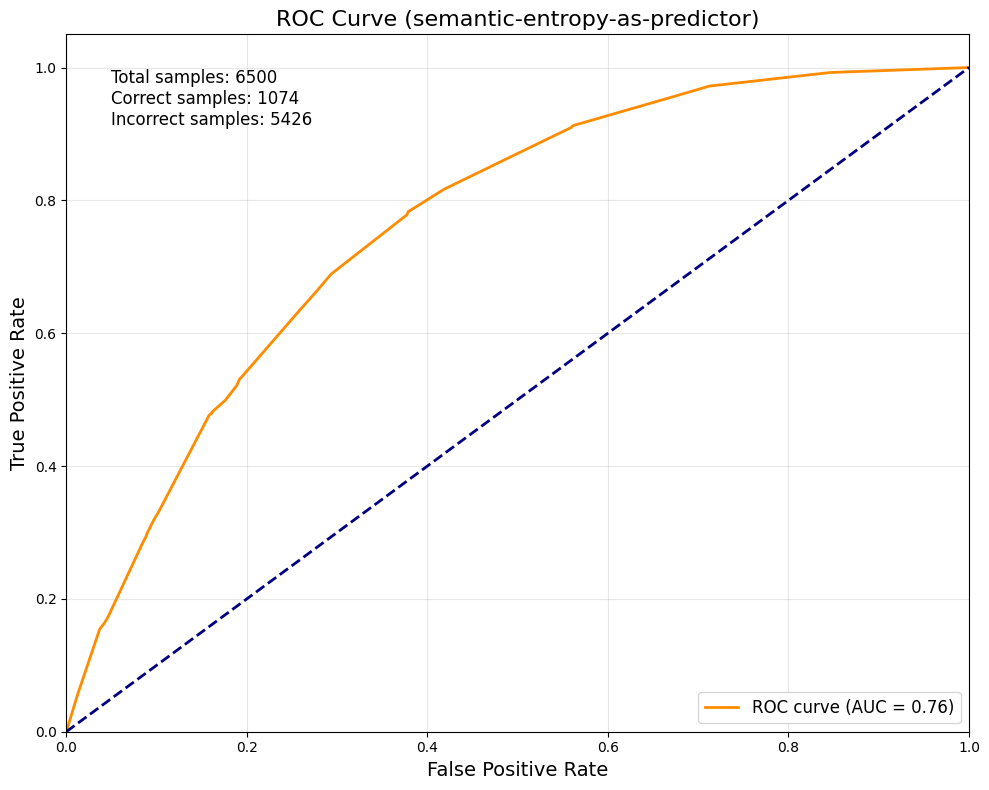

AUC-ROC Score: 0.7648
Best Threshold: 2.1700


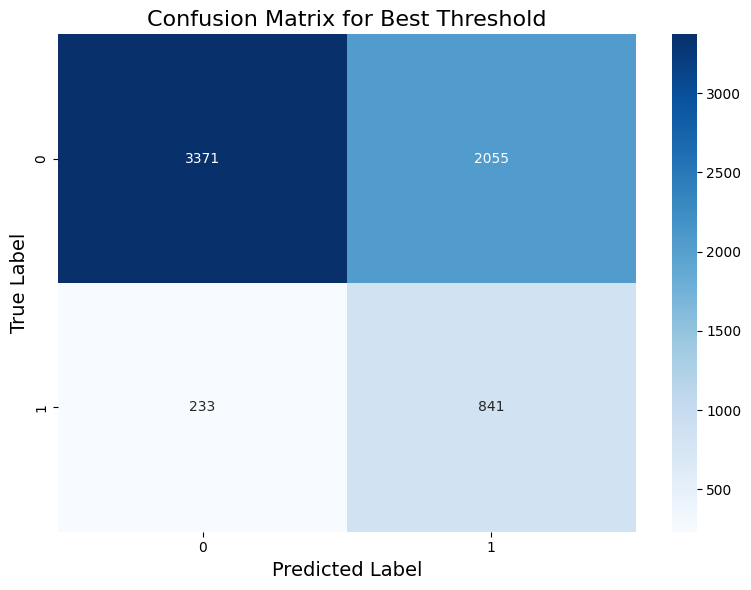


Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.94      0.62      0.75      5426
     Correct       0.29      0.78      0.42      1074

    accuracy                           0.65      6500
   macro avg       0.61      0.70      0.59      6500
weighted avg       0.83      0.65      0.69      6500



In [74]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your DataFrame with 'entropy' and 'is_correct' columns
# If you're only using train_data, replace combined_df with train_data

# Prepare the data
y_true = combined_df['is_correct']
y_scores = -combined_df['entropy']  # Negative because lower entropy means higher confidence

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find the best threshold using Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

# Create predictions using the best threshold
y_pred = (y_scores >= best_threshold).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the ROC curve plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve (semantic-entropy-as-predictor)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add text with data statistics
plt.text(0.05, 0.95, f"Total samples: {len(y_true)}\nCorrect samples: {sum(y_true)}\nIncorrect samples: {len(y_true) - sum(y_true)}",
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)
plt.tight_layout()
plt.show()

# Print AUC score and best threshold
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Best Threshold: {-best_threshold:.4f}")  # Note: we negate it back to get the original entropy threshold

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Threshold', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Incorrect', 'Correct']))

## Plain logistic regression with is_correct as the label

Shape of training data: (5200, 2048)
Shape of test data: (1300, 2048)
Proportion of correct answers in training set: 0.16538461538461538
Proportion of correct answers in test set: 0.1646153846153846
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Number of features selected: 500

y_train_pred_proba distribution:
(array([ 993, 2674, 1205,  236,   46,   21,   10,    9,    3,    3]), array([0.00252227, 0.09827914, 0.19403602, 0.28979289, 0.38554977,
       0.48130664, 0.57706351, 0.67282039, 0.76857726, 0.86433414,
       0.96009101]))

y_test_pred_proba distribution:
(array([139, 498, 400, 193,  40,  13,  11,   2,   0,   4]), array([0.00285132, 0.07582566, 0.14879999, 0.22177432, 0.29474865,
       0.36772298, 0.44069731, 0.51367165, 0.58664598, 0.65962031,
       0.73259464]))

y_train_correct distribution: [4340  860]
y_test_correct distribution: [1086  214]

Best threshold for correctness (determined from training data): 0.2121


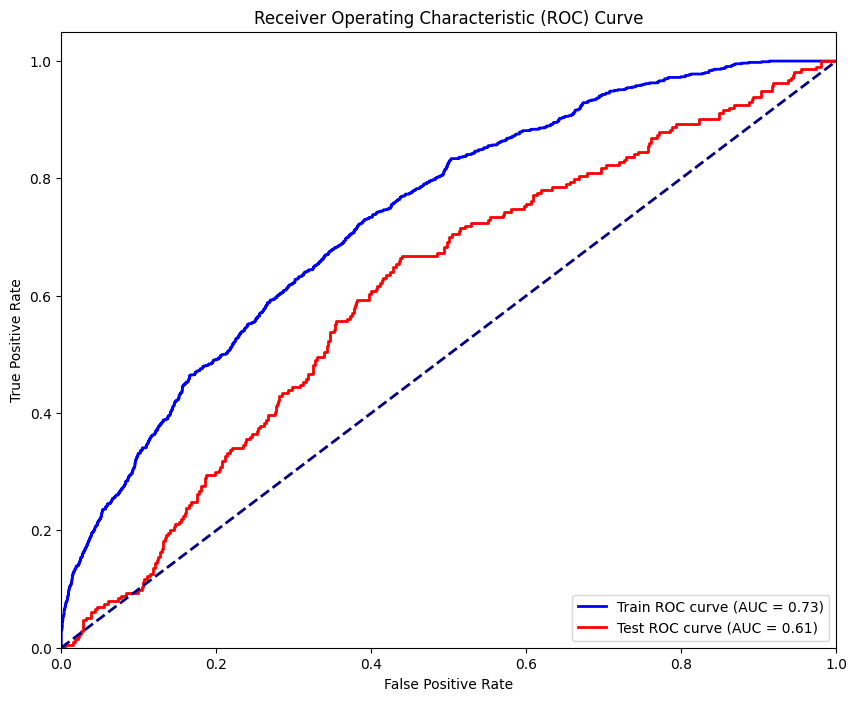


Classification Report (Train) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.89      0.82      0.85      4340
     Correct       0.34      0.48      0.40       860

    accuracy                           0.76      5200
   macro avg       0.62      0.65      0.63      5200
weighted avg       0.80      0.76      0.78      5200


Classification Report (Test) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.86      0.79      0.82      1086
     Correct       0.23      0.32      0.27       214

    accuracy                           0.71      1300
   macro avg       0.54      0.56      0.55      1300
weighted avg       0.75      0.71      0.73      1300



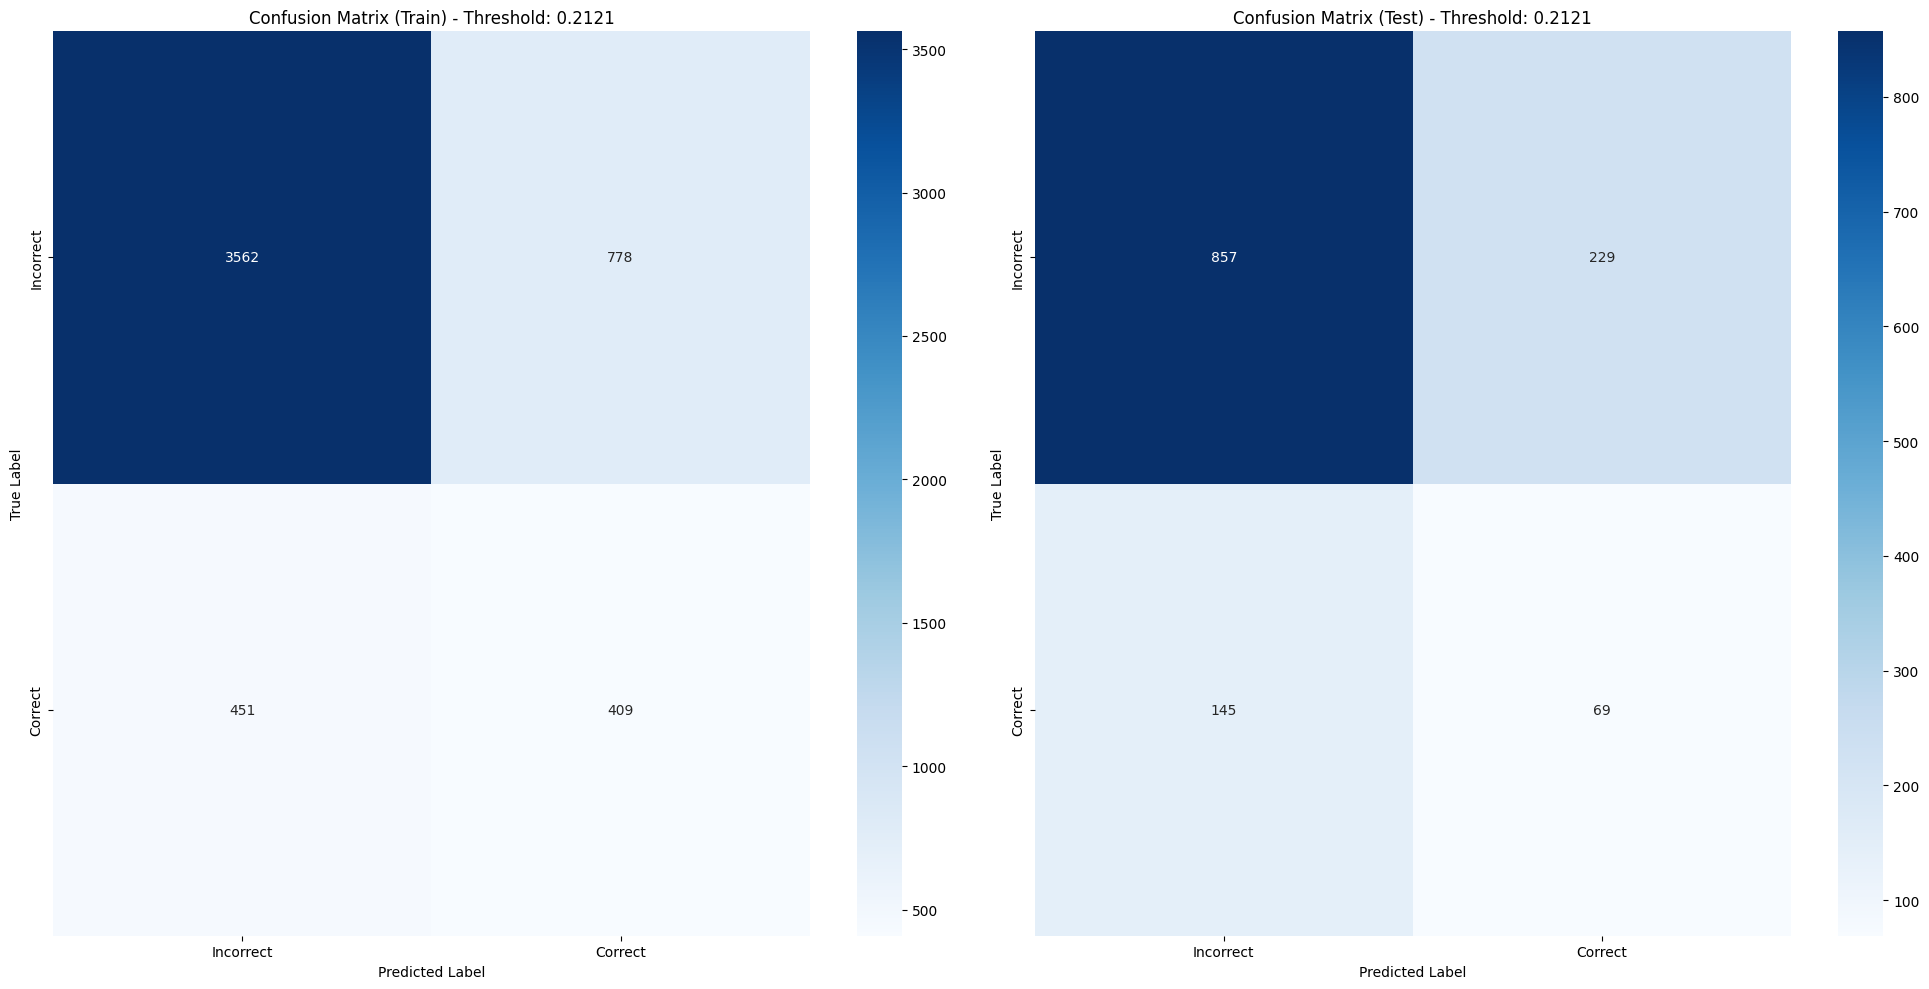

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
import ast

# Function to convert string representation of list to numpy array
def string_to_numpy(s):
    return np.array(ast.literal_eval(s))

# Prepare data for classification
X = np.stack(combined_df['embedding'].apply(string_to_numpy).values)
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_correct, y_test_correct = train_test_split(X, y_correct, test_size=0.2, random_state=42)

# The rest of the code remains the same
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# The rest of the code remains unchanged
...

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Create a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga')

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_correct)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best threshold using only training data
best_threshold = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for correctness (determined from training data): {best_threshold:.4f}")

# Create predictions using the best threshold for both train and test
y_train_pred_optimized = (y_train_pred_proba >= best_threshold).astype(int)
y_test_pred_optimized = (y_test_pred_proba >= best_threshold).astype(int)

# Calculate ROC curve and AUC for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized threshold
print("\nClassification Report (Train) - Optimized Threshold:")
print(classification_report(y_train_correct, y_train_pred_optimized, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold:")
print(classification_report(y_test_correct, y_test_pred_optimized, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train) - Threshold: {best_threshold:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Incorrect', 'Correct'])
ax1.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test) - Threshold: {best_threshold:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['Incorrect', 'Correct'])
ax2.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

## Class-weighted Logistic Regression with Is_Correct as the Label

Shape of training data: (5200, 2048)
Shape of test data: (1300, 2048)
Proportion of correct answers in training set: 0.16538461538461538
Proportion of correct answers in test set: 0.1646153846153846
Class weights: {False: 0.5990783410138248, True: 3.0232558139534884}
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Number of features selected: 500

y_train_pred_proba distribution:
(array([ 142,  217,  515,  954, 1240, 1178,  688,  189,   56,   21]), array([0.00145534, 0.10067581, 0.19989627, 0.29911674, 0.39833721,
       0.49755767, 0.59677814, 0.6959986 , 0.79521907, 0.89443953,
       0.99366   ]))

y_test_pred_proba distribution:
(array([ 42,  54, 133, 203, 288, 295, 200,  59,  20,   6]), array([0.00512793, 0.10053828, 0.19594864, 0.291359  , 0.38676935,
       0.48217971, 0.57759006, 0.67300042, 0.76841078, 0.86382113,
       0.95923149]))

y_train_correct distribution: [4340  860]
y_test_correct distribution: [1086  214]

Best threshold for correctness (determined from training data

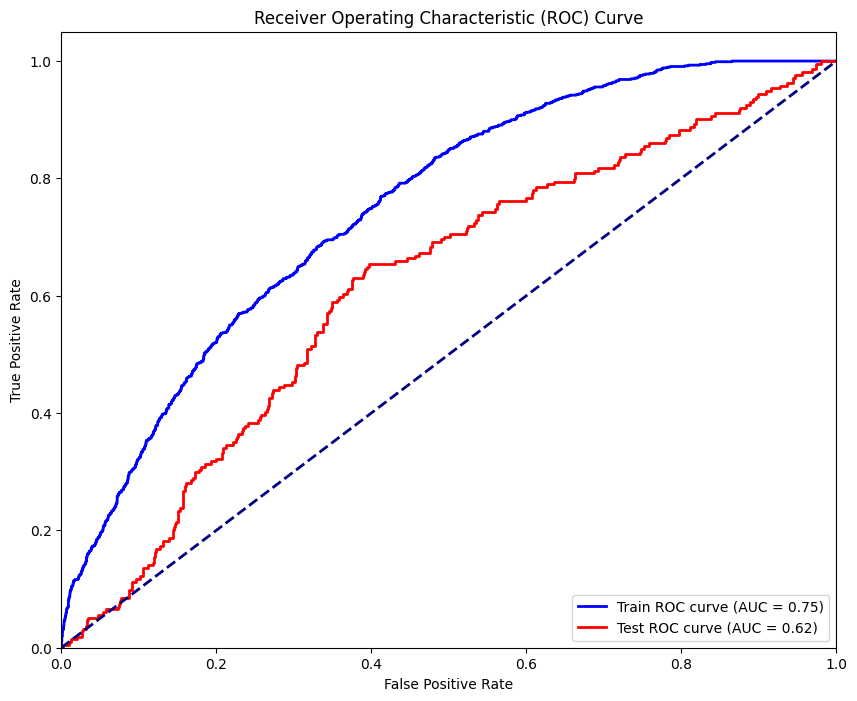


Classification Report (Train) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.90      0.76      0.83      4340
     Correct       0.32      0.57      0.41       860

    accuracy                           0.73      5200
   macro avg       0.61      0.67      0.62      5200
weighted avg       0.80      0.73      0.76      5200


Classification Report (Test) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.86      0.74      0.80      1086
     Correct       0.23      0.40      0.29       214

    accuracy                           0.68      1300
   macro avg       0.55      0.57      0.54      1300
weighted avg       0.76      0.68      0.71      1300



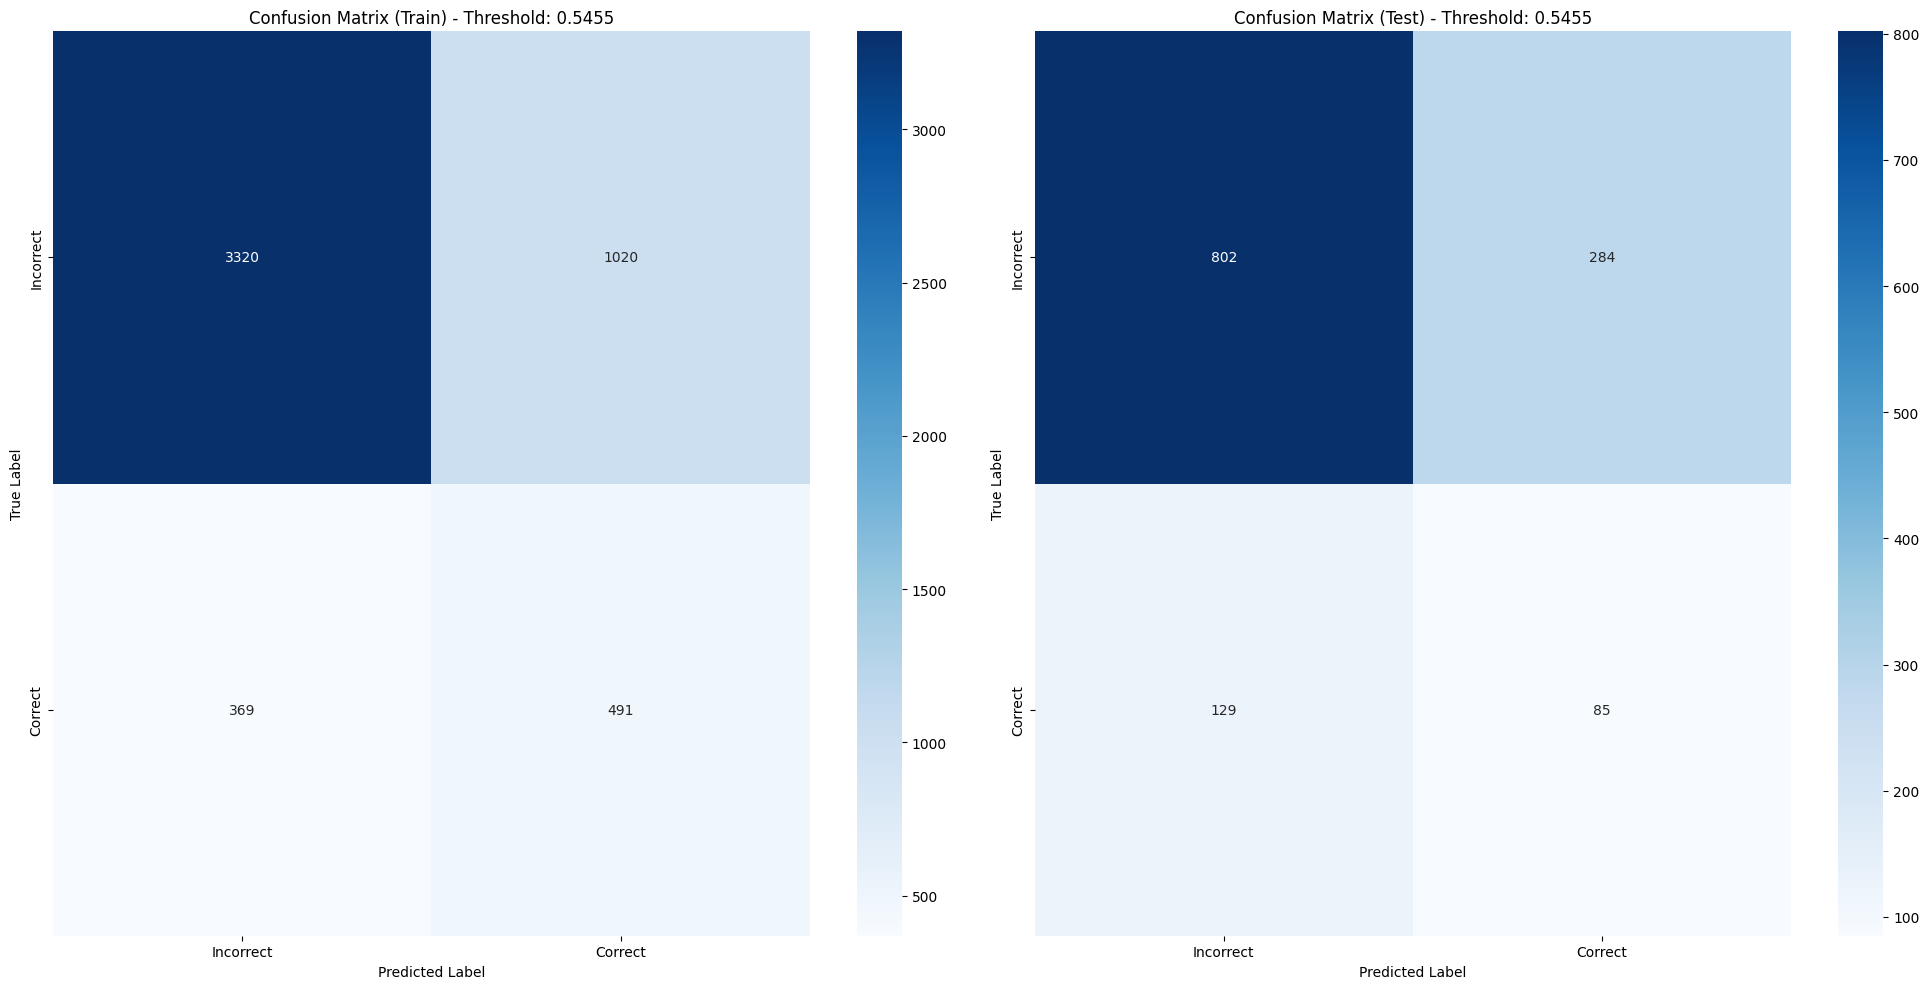

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import ast

# Function to convert string representation of list to numpy array
def string_to_numpy(s):
    return np.array(ast.literal_eval(s))

# Prepare data for classification
X = np.stack(combined_df['embedding'].apply(string_to_numpy).values)
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_correct, y_test_correct = train_test_split(X, y_correct, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_correct), y=y_train_correct)
class_weight_dict = dict(zip(np.unique(y_train_correct), class_weights))

print("Class weights:", class_weight_dict)

# Create a logistic regression model with class weights
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga', class_weight=class_weight_dict)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_correct)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best threshold using only training data
best_threshold = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for correctness (determined from training data): {best_threshold:.4f}")

# Create predictions using the best threshold for both train and test
y_train_pred_optimized = (y_train_pred_proba >= best_threshold).astype(int)
y_test_pred_optimized = (y_test_pred_proba >= best_threshold).astype(int)

# Calculate ROC curve and AUC for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized threshold
print("\nClassification Report (Train) - Optimized Threshold:")
print(classification_report(y_train_correct, y_train_pred_optimized, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold:")
print(classification_report(y_test_correct, y_test_pred_optimized, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train) - Threshold: {best_threshold:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Incorrect', 'Correct'])
ax1.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test) - Threshold: {best_threshold:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['Incorrect', 'Correct'])
ax2.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

## Now, let's train using entropy score as the label. and then use it as a proxy for the hallucination

Shape of training data: (5200, 2048)
Shape of test data: (1300, 2048)
Proportion of low entropy in training set: 0.44346153846153846
Proportion of low entropy in test set: 0.44461538461538463
Proportion of correct answers in training set: 0.16538461538461538
Proportion of correct answers in test set: 0.1646153846153846
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Number of features selected: 500

y_train_pred_proba distribution:
(array([ 113,  245,  710, 1103, 1136,  974,  511,  227,  116,   65]), array([8.43719378e-04, 1.00201712e-01, 1.99559704e-01, 2.98917697e-01,
       3.98275689e-01, 4.97633682e-01, 5.96991674e-01, 6.96349667e-01,
       7.95707659e-01, 8.95065652e-01, 9.94423644e-01]))

y_test_pred_proba distribution:
(array([ 36,  64, 185, 262, 286, 249, 121,  50,  30,  17]), array([0.00480904, 0.10356555, 0.20232206, 0.30107856, 0.39983507,
       0.49859158, 0.59734809, 0.69610459, 0.7948611 , 0.89361761,
       0.99237411]))

y_train_entropy distribution: [2894 2306]
y_test

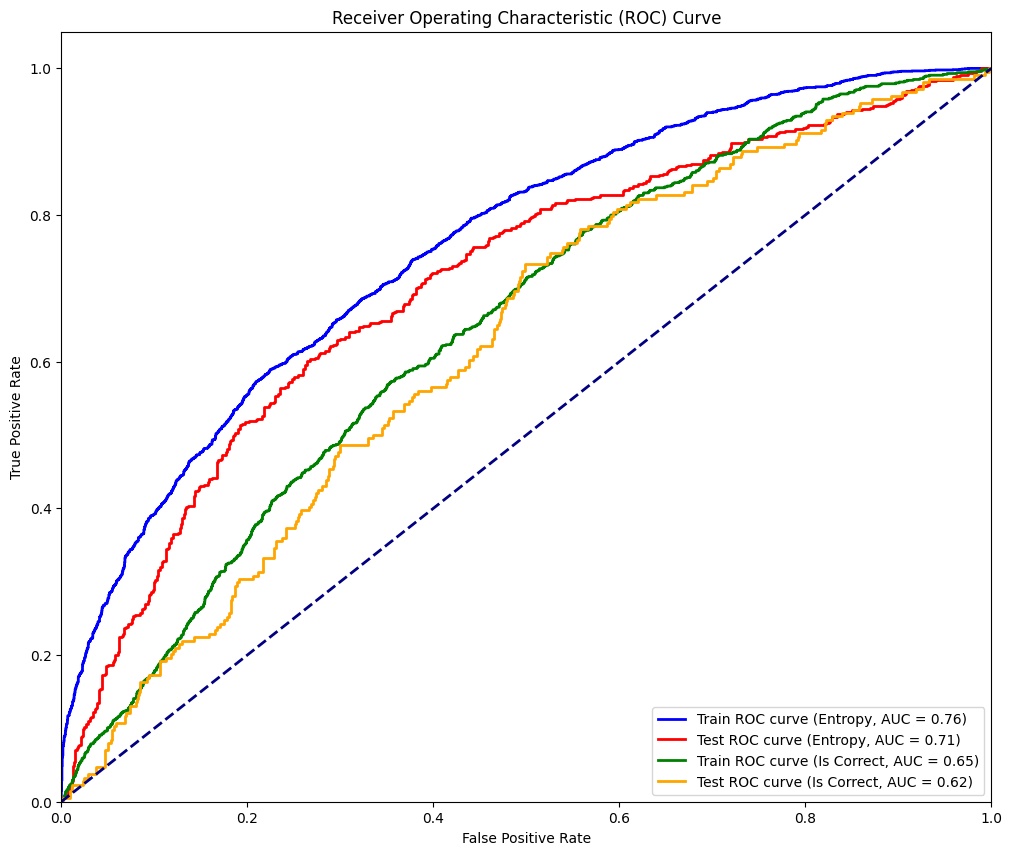


Classification Report (Train) - Optimized Threshold (Entropy):
              precision    recall  f1-score   support

High Entropy       0.79      0.51      0.62      2894
 Low Entropy       0.58      0.83      0.68      2306

    accuracy                           0.65      5200
   macro avg       0.68      0.67      0.65      5200
weighted avg       0.69      0.65      0.65      5200


Classification Report (Test) - Optimized Threshold (Entropy):
              precision    recall  f1-score   support

High Entropy       0.75      0.50      0.60       722
 Low Entropy       0.56      0.80      0.66       578

    accuracy                           0.63      1300
   macro avg       0.66      0.65      0.63      1300
weighted avg       0.67      0.63      0.62      1300


Classification Report (Train) - Optimized Threshold (Is Correct):
              precision    recall  f1-score   support

   Incorrect       0.88      0.64      0.74      4340
     Correct       0.24      0.58      0.34

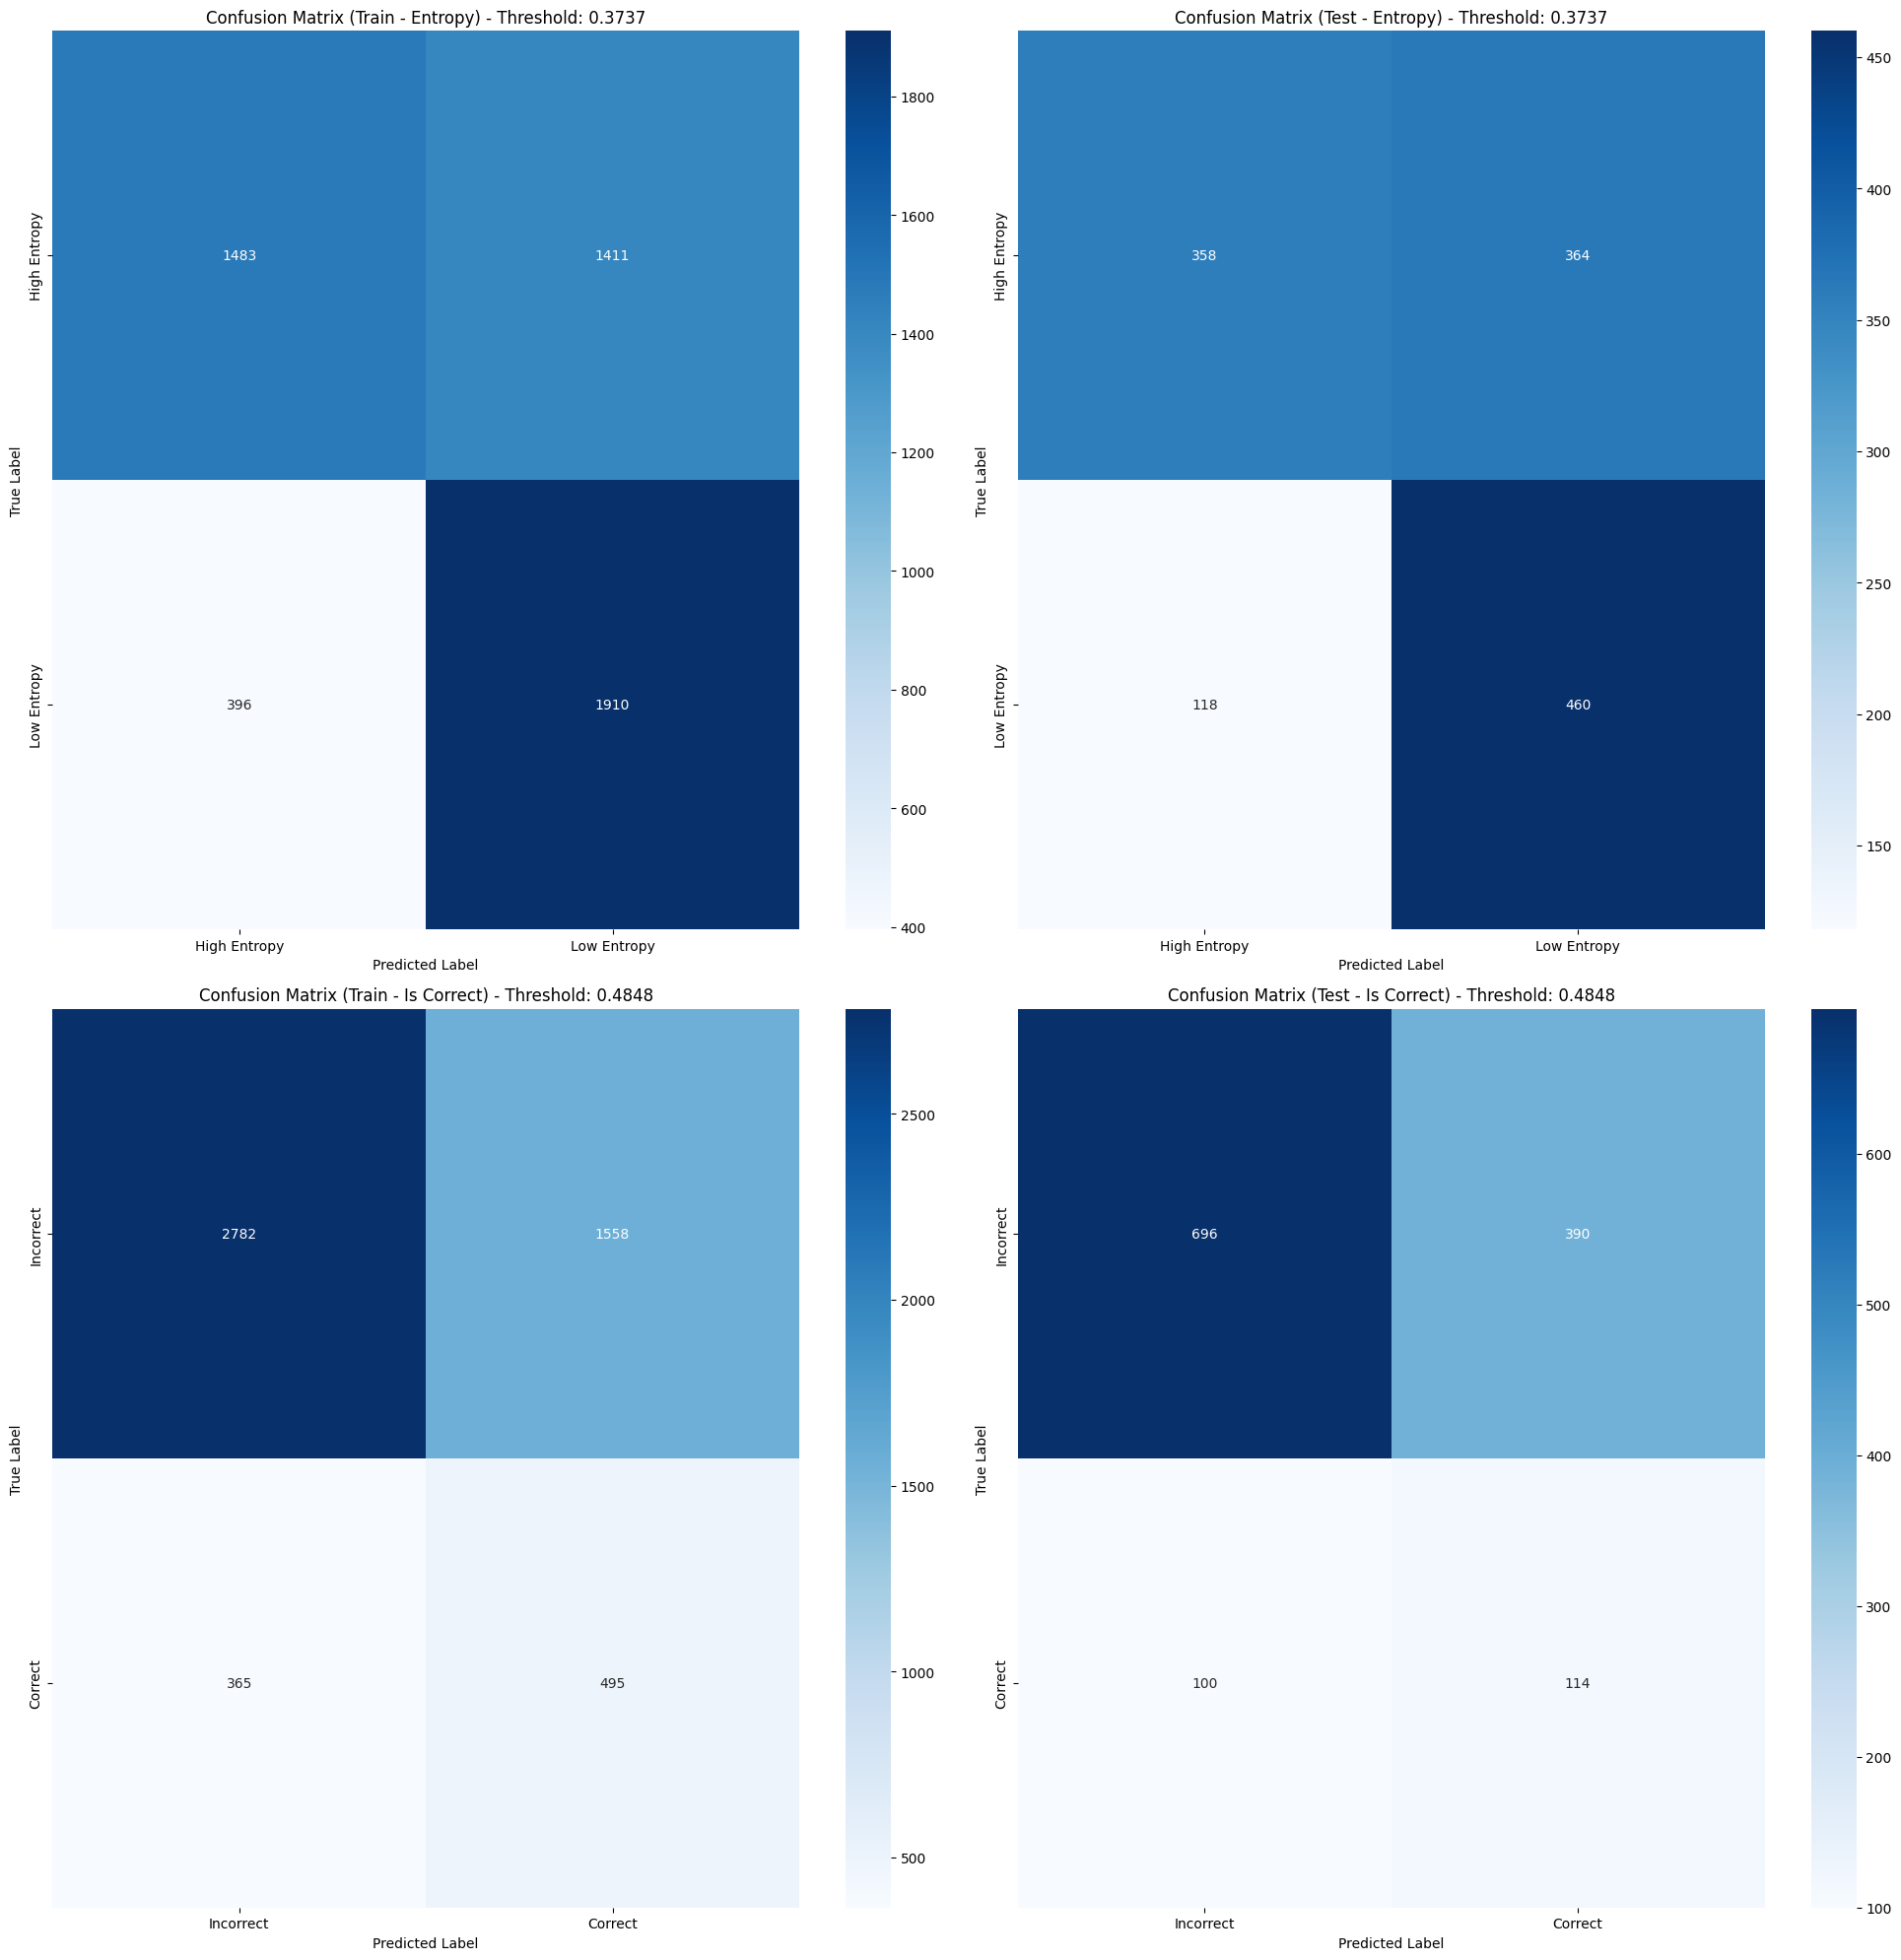

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
import ast

# Function to convert string representation of list to numpy array
def string_to_numpy(s):
    return np.array(ast.literal_eval(s))

# Create new column based on entropy (inverted)
combined_df['entropy_label'] = (combined_df['entropy'] < 2.17).astype(int)

# Prepare data for classification
X = np.stack(combined_df['embedding'].apply(string_to_numpy).values)
y_entropy = combined_df['entropy_label'].values
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_entropy, y_test_entropy, y_train_correct, y_test_correct = train_test_split(X, y_entropy, y_correct, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of low entropy in training set:", y_train_entropy.mean())
print("Proportion of low entropy in test set:", y_test_entropy.mean())
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Create a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga')

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_entropy)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_entropy distribution:", np.bincount(y_train_entropy))
print("y_test_entropy distribution:", np.bincount(y_test_entropy))
print("y_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best thresholds using only training data
best_threshold_entropy = find_best_threshold(y_train_entropy, y_train_pred_proba)
best_threshold_correct = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for entropy (determined from training data): {best_threshold_entropy:.4f}")
print(f"Best threshold for correctness (determined from training data): {best_threshold_correct:.4f}")

# Create predictions using the best thresholds for both train and test
y_train_pred_optimized_entropy = (y_train_pred_proba >= best_threshold_entropy).astype(int)
y_test_pred_optimized_entropy = (y_test_pred_proba >= best_threshold_entropy).astype(int)
y_train_pred_optimized_correct = (y_train_pred_proba >= best_threshold_correct).astype(int)
y_test_pred_optimized_correct = (y_test_pred_proba >= best_threshold_correct).astype(int)

# Calculate ROC curve and AUC for train and test sets (entropy labels)
fpr_train_entropy, tpr_train_entropy, _ = roc_curve(y_train_entropy, y_train_pred_proba)
roc_auc_train_entropy = roc_auc_score(y_train_entropy, y_train_pred_proba)
fpr_test_entropy, tpr_test_entropy, _ = roc_curve(y_test_entropy, y_test_pred_proba)
roc_auc_test_entropy = roc_auc_score(y_test_entropy, y_test_pred_proba)

# Calculate ROC curve and AUC for train and test sets (is_correct labels)
fpr_train_correct, tpr_train_correct, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train_correct = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test_correct, tpr_test_correct, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test_correct = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curves
plt.figure(figsize=(12, 10))
plt.plot(fpr_train_entropy, tpr_train_entropy, color='blue', lw=2, label=f'Train ROC curve (Entropy, AUC = {roc_auc_train_entropy:.2f})')
plt.plot(fpr_test_entropy, tpr_test_entropy, color='red', lw=2, label=f'Test ROC curve (Entropy, AUC = {roc_auc_test_entropy:.2f})')
plt.plot(fpr_train_correct, tpr_train_correct, color='green', lw=2, label=f'Train ROC curve (Is Correct, AUC = {roc_auc_train_correct:.2f})')
plt.plot(fpr_test_correct, tpr_test_correct, color='orange', lw=2, label=f'Test ROC curve (Is Correct, AUC = {roc_auc_test_correct:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized thresholds
print("\nClassification Report (Train) - Optimized Threshold (Entropy):")
print(classification_report(y_train_entropy, y_train_pred_optimized_entropy, target_names=['High Entropy', 'Low Entropy']))
print("\nClassification Report (Test) - Optimized Threshold (Entropy):")
print(classification_report(y_test_entropy, y_test_pred_optimized_entropy, target_names=['High Entropy', 'Low Entropy']))

print("\nClassification Report (Train) - Optimized Threshold (Is Correct):")
print(classification_report(y_train_correct, y_train_pred_optimized_correct, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold (Is Correct):")
print(classification_report(y_test_correct, y_test_pred_optimized_correct, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized thresholds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

sns.heatmap(confusion_matrix(y_train_entropy, y_train_pred_optimized_entropy), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train - Entropy) - Threshold: {best_threshold_entropy:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['High Entropy', 'Low Entropy'])
ax1.set_yticklabels(['High Entropy', 'Low Entropy'])

sns.heatmap(confusion_matrix(y_test_entropy, y_test_pred_optimized_entropy), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test - Entropy) - Threshold: {best_threshold_entropy:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['High Entropy', 'Low Entropy'])
ax2.set_yticklabels(['High Entropy', 'Low Entropy'])

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized_correct), annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'Confusion Matrix (Train - Is Correct) - Threshold: {best_threshold_correct:.4f}')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')
ax3.set_xticklabels(['Incorrect', 'Correct'])
ax3.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized_correct), annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title(f'Confusion Matrix (Test - Is Correct) - Threshold: {best_threshold_correct:.4f}')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')
ax4.set_xticklabels(['Incorrect', 'Correct'])
ax4.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

In [47]:
import ast

def extract_options(choices_string):
    try:
        # Convert the string to a dictionary
        choices_dict = ast.literal_eval(choices_string)

        # Extract the 'text' values
        options = choices_dict['text']

        # Ensure we have exactly 5 options
        if len(options) != 5:
            raise ValueError("Expected 5 options, but found {len(options)}")

        return options
    except (ValueError, KeyError, SyntaxError) as e:
        print(f"Error parsing choices: {e}")
        return []

# Example usage:
# sample_choices = "{'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['pizza parlor', 'store', 'house', 'pie shop', 'stove']}"
# options = extract_options(sample_choices)
# print(options)

In [ ]:
# Usage example:
# Assuming you have gemma_model, gemma_tokenizer, and device already set up
input_data = test_ds_40[2]  # Or any other index
result = process_single_input(input_data, gemma_model, gemma_tokenizer, device)

print(result['generated_answer'])